# FMD Scorecard KPIs
This notebook has a few objectives. 

- Come as close as we can to replicating the results reported in previous years. This lets us know that we are all looking at the same data and seeing the same thing
- Show the results we'll get with modified results 

Note that in the past, the Department of General Services has used a multi-phase process to compute KPIs, including SQL Queries and Excel formulas. No one person could see the entire process, beginning with the data in the database (the input) and ending with reported KPI. 

Part of the intention of this notebook is to build _transparency_ and _reproducibility_ by capturing the entire end-to-end process in one place.

## Setup

### Import packages

In [1]:
# workhorse modules
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import re
from pathlib import Path
import seaborn as sns

import datadotworld as dw

# local utility functions
from utils import (
    add_cm_benchmarks,
    add_fiscal_year,
    set_pd_params,
    tidy_up_df,
    cast_dtypes,
    glue_date_time,
    compute_days_to_completion,
    consolidate_prob_types,
    compute_pm_cm,
    compute_kpi_table,
)

### Set pandas options
This makes Pandas print all rows and columns to the output when requested.

In [2]:
set_pd_params()

pd.options.mode.chained_assignment = None  # default='warn'

### Import the data from Data.World
Data is a copy of Archibus's `wrhwr` table. To see the exact query used to generate the input data, see `/sql/input_for_FMD_KPIs.sql`.

In [3]:
kpis_raw = dw.query(
    dataset_key="dgsbpio/auditfinding3", query="select * from wrhwr_01052021"
).dataframe

print(f"The work orders dataframe has {kpis_raw.shape[0]:,} rows.")

kpis_raw.sample(3, random_state=444)[["wr_id", "prob_type"]]

The work orders dataframe has 69,981 rows.


,wr_id,prob_type
15761,79304,HVAC
1722,60757,OVERHDDOOR
45524,110899,ELEC/GENERAL


In [4]:
users = dw.query(
    dataset_key="dgsbpio/auditfinding3", query="select * from archibus_user_roles"
).dataframe

users = users.applymap(lambda x: x.strip() if isinstance(x, str) else x)

## Data cleaning

### Basic cleaning
- removes white spaces in strings to facilitate matching, 
- drops rows with no problem type, 
- renames a few columns

In [5]:
wr_tidy = cast_dtypes(kpis_raw)
wr_tidy = tidy_up_df(wr_tidy)

print(f"The tidied work orders dataframe has {wr_tidy.shape[0]:,} rows.")

The tidied work orders dataframe has 69,889 rows.


### Combine date and time columns to get timestamps
This takes the date from a date column and the time from a time column and combines them into a single timestamp.

This transformation allows us to know the time to completion with greater precision. 

In [6]:
# glue the date and time for request
wr_dt = glue_date_time(wr_tidy, "date_requested", "time_requested", "requested_dt")

# glue the date and time for completion
wr_dt = glue_date_time(wr_dt, "date_completed", "time_completed", "completed_dt")

# convert "date closed_order" to date time (this column has no time information)
wr_dt["date_closed"] = wr_dt["date_closed"].astype("datetime64")

### Examine the cleaned data

In [7]:
wr_dt[
    [
        "wr_id",
        "problem_type",
        "requested_dt",
        "completed_dt",
        "date_closed",
        "status",
    ]
].sample(3, random_state=451)

,wr_id,problem_type,requested_dt,completed_dt,date_closed,status
43137,108510,DOOR,2018-07-24 13:21:40,2018-10-10 08:40:53,2020-01-24 13:54:28.440,Clo
38868,104240,LOCK,2018-04-20 10:42:51,2018-04-20 10:44:24,2018-04-30 15:29:11.933,Clo
15936,79457,HVAC,2016-12-02 14:52:27,2016-12-07 10:33:22,2017-02-13 13:06:36.627,Clo


## Data preparation

In [8]:
wr_joined = wr_dt.merge(
    users[["user_name", "role_name"]],
    how="left",
    left_on="requestor",
    right_on="user_name",
)

### Include days to completion

In [9]:
wr_durations = compute_days_to_completion(wr_joined)

In [10]:
wr_durations[
    [
        "wr_id",
        "role_name",
        "problem_type",
        "requested_dt",
        "completed_dt",
        "date_closed",
        "days_to_completion",
        "status",
    ]
].sample(3, random_state=446)

,wr_id,role_name,problem_type,requested_dt,completed_dt,date_closed,days_to_completion,status
requested_dt,,,,,,,,
2018-08-09 09:27:10,109226,SUPERVISOR - BOC,BUILDING INTERIOR INSPECTION,2018-08-09 09:27:10,2018-08-09 09:28:27,2018-08-15 08:21:54.897,0.00,Clo
2017-04-13 13:58:55,86579,SUPERVISOR-DISPATCHER - BOC,HVAC,2017-04-13 13:58:55,2017-04-17 09:12:10,2020-03-24 09:26:06.893,3.80,Clo
2019-04-11 10:04:52,119505,GATEKEEPER-RESTRICTED - BOC,PLUMB/OTHER,2019-04-11 10:04:52,2019-07-24 09:23:49,NaT,103.97,Com


### Add fiscal year
Note that the function `entirely_within_fiscal_year()` keeps only those rows where the work order was requested and closed in the same fiscal year. __Other rows that straddle two fiscal years are dropped__.

For comparison, I've included the function `add_fiscal_year()`, which derives the fiscal year from the request date or from the completion date — and drops no rows.

In [11]:
wr_fy = add_fiscal_year(wr_durations, assign_fy_on="closure")

In [12]:
cond_fy = wr_fy["fiscal_year"].isin(range(2016, 2022))
wr_fy = wr_fy[cond_fy]

## KPI: % PMs Completed On Time 
The goal here is to filter the data down to preventive maintenance only, and then show how many are completed before a given benchmark.

### Filter to PM only, and for relevant fiscal years only

In [13]:
pm_list = [
    "BUILDING INTERIOR INSPECTION",
    "BUILDING PM",
    "HVAC|PM",
    "INSEPCTION",
    "PREVENTIVE MAINT",
]


cond_pm = wr_fy["problem_type"].isin(pm_list)

wr_pm = wr_fy[cond_pm]
wr_pm["benchmark"] = 21

print(f"The filtered work orders dataframe has {wr_pm.shape[0]:,} rows.")

The filtered work orders dataframe has 6,940 rows.


#### Compute the benchmark and add 'is_on_time' column

In [14]:
def compute_is_on_time(row):
    row["is_on_time"] = row["days_to_completion"] <= row["benchmark"]
    return row


pms_on_time = wr_pm.apply(compute_is_on_time, axis=1)

#### Group by fiscal year and get % on time

In [15]:
pm_compliance = compute_kpi_table(pms_on_time, "percent_PMs_on_time", "total_PMs")
pm_compliance

,percent_PMs_on_time,total_PMs
fiscal_year,,
2016,80.56,355
2017,49.07,1337
2018,78.01,1155
2019,86.38,815
2020,40.91,2256
2021,24.46,1022


## KPI: PM:CM Ratio

The two lists below contain the exact same problem types mentioned in last year's scorecard. So we would expect to be able to replicate last year's results closely.

In [16]:
CM_list = [
    "BOILER",
    "CHILLERS",
    "COOLING TOWERS",
    "HVAC",
    "HVAC INFRASTRUCTURE",
    "HVAC|REPAIR",
]

PM_list = [
    "HVAC|PM",
    "PREVENTIVE MAINT",
]

### Filter to HVAC rows only

In [17]:
cond_cm = wr_fy["problem_type"].isin(CM_list)
cond_pm = wr_fy["problem_type"].isin(PM_list)

wr_HVAC = wr_fy[cond_cm | cond_pm]
wr_HVAC["is_pm"] = wr_HVAC["problem_type"].isin(PM_list)

print(f"We've gone from {len(wr_fy):,} rows to {len(wr_HVAC):,} rows.")

We've gone from 57,290 rows to 15,263 rows.


### Compute all PM/CM stats by fiscal year

In [18]:
pm_cm_results = compute_pm_cm(wr_HVAC, PM_list)

In [19]:
pm_cm_results

,year,pm_cm_ratio,count_cm,count_pm,count_hvac
0,2016,0.59,549,326,875
1,2017,0.64,1979,1258,3237
2,2018,0.63,1735,1101,2836
3,2019,0.35,1325,466,1791
4,2020,0.85,2524,2133,4657
5,2021,1.19,854,1013,1867


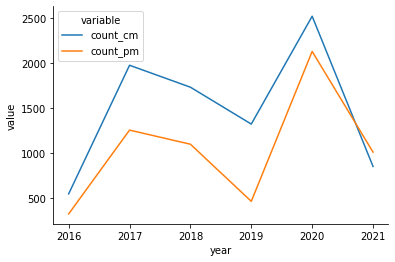

In [20]:
count_plot_data = pd.melt(
    pm_cm_results, id_vars=["year"], value_vars=["count_cm", "count_pm"]
)

sns.lineplot(data=count_plot_data, y="value", x="year", hue="variable")

sns.despine()

## KPI: Percent of CM Work Requests Completed On-Time
Here are the key facts needed to understand the agency's new method for computing this KPI:

- Only CM problem types are considered, so all PM work orders are dropped.
- The work orders are first assigned a "primary" problem type, which consolidates the number of problem types
- Each of these primary problem types has a benchmark, which is then added to the work request's row
- Finally, the work order is determined to be on-time based on comparing its time to completion to its benchmark

In [26]:
wr_cm = wr_fy.copy()

consolidated_wrs = wr_cm.apply(consolidate_prob_types, axis=1)

cond_cm = consolidated_wrs["primary"] != "PREVENTIVE"
consolidated_cms = consolidated_wrs[cond_cm]

print(
    f"Dropping some unbenchmarked small categories takes us from {len(consolidated_wrs):,} rows to {len(consolidated_cms):,} rows."
)

Dropping some unbenchmarked small categories takes us from 57,290 rows to 50,253 rows.


In [23]:
cms_benchmarked = consolidated_cms.apply(add_cm_benchmarks, axis=1)

cms_benchmarked.sample(6, random_state=444)[
    ["problem_type", "primary", "benchmark", "days_to_completion"]
]

,problem_type,primary,benchmark,days_to_completion
requested_dt,,,,
2019-01-11 15:38:53,PLUMBING FIXTURES,PLUMBING,14.0,13.74
2018-08-03 11:21:50,BATHROOM_FIXT,BATHROOM,14.0,191.87
2016-10-21 07:24:52,OTHER,OTHER-INTERNAL,7.0,2.09
2017-01-05 14:47:02,PAINTING,PAINTING,21.0,13.80
2018-08-28 08:53:41,LOCK,LOCK,7.0,1.94
2018-10-09 06:55:49,CEILTILE,CEILTILE,14.0,17.12


In [24]:
cms_on_time = cms_benchmarked.apply(compute_is_on_time, axis=1)

In [25]:
cm_compliance = compute_kpi_table(cms_on_time, "Percent CMs on Time", "Count of CMs")
cm_compliance

,Percent CMs on Time,Count of CMs
fiscal_year,,
2016,85.47,6106
2017,71.82,12973
2018,70.91,9978
2019,64.26,5811
2020,50.01,9346
2021,28.35,6039
